<a href="https://colab.research.google.com/github/maximum4645/ComputerVision/blob/main/object_detection_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset

In [19]:
import torch
import torchvision
import torchvision.transforms as T
from torch.utils.data import random_split
from torch.utils.data import Subset

In [2]:
# Define the transform
transform = T.Compose([T.ToTensor()])

# Download the dataset
dataset = torchvision.datasets.VOCDetection(root='.', year='2012', image_set='train', download=True, transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = random_split(dataset, [train_size, test_size])
categories = ["__background__", "aeroplane", "bicycle", "bird", "boat",
              "bottle", "bus", "car", "cat", "chair", "cow", "diningtable",
              "dog", "horse", "motorbike", "person", "pottedplant",
              "sheep", "sofa", "train", "tvmonitor"]
print('Number of train set :', len(train_set))
print('Number of test set :', len(test_set))
print('Number of classes :', len(categories))

Using downloaded and verified file: ./VOCtrainval_11-May-2012.tar
Extracting ./VOCtrainval_11-May-2012.tar to .
Number of train set : 4573
Number of test set : 1144
Number of classes : 21


# Model

In [3]:
# Load the pretrained Faster R-CNN model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Set the model to evaluation mode
model.eval()
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

## Modify the output layer

In [4]:
# Number of classes in the Pascal VOC dataset (20 classes + background)
num_classes = 21

# Get the input features of the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# Replace the head of the model
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

## Freeze some layers

In [5]:
# Freeze all the layers in the backbone
for param in model.backbone.parameters():
    param.requires_grad = False

# Prediction

## Understanding the dataset and Getting dataloaders

In [20]:
# Define a custom collate function
def collate_fn(batch):
    return tuple(zip(*batch))

def get_dataloaders(train_set, test_set, transform, subset_size, val_size, batch_size):
    train_set.dataset.transform = transform
    test_set.dataset.transform = transform
    if subset_size:
        indices = torch.randperm(len(train_set))[:subset_size]
        train_subset = Subset(train_set, indices)
        train_size = int((1 - val_size) * subset_size)
        val_size = subset_size - train_size
        train_set, val_set = random_split(train_subset, [train_size, val_size])
    else:
        train_size = int((1 - val_size) * len(train_set))
        val_size = len(train_set) - train_size
        train_set, val_set = random_split(train_set, [train_size, val_size])

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=collate_fn)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2, collate_fn=collate_fn)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2, collate_fn=collate_fn)

    return train_loader, val_loader, test_loader

In [29]:
# Define the transform
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
subset_size = 1000
val_size = 0.2

train_loader, val_loader, test_loader = get_dataloaders(
                                            train_set = train_set,
                                            test_set = test_set,
                                            transform = transform,
                                            subset_size = subset_size,
                                            val_size = val_size,
                                            batch_size = 8)

In [30]:
images, targets = next(iter(train_loader))
print(targets[0], '\n')
print(targets[0].keys(), '\n')
print(targets[0]['annotation'].keys(), '\n')
print()
for key in targets[0]['annotation'].keys():
    print(key, ':', targets[0]['annotation'][key])
print()
print(targets[0]['annotation']['object'][0])
print()
print(targets[0]['annotation']['object'][0]['bndbox'])

{'annotation': {'filename': '2009_004766.jpg', 'folder': 'VOC2012', 'object': [{'name': 'train', 'bndbox': {'xmax': '425', 'xmin': '47', 'ymax': '275', 'ymin': '65'}, 'difficult': '0', 'occluded': '0', 'pose': 'Frontal', 'truncated': '0'}], 'segmented': '0', 'size': {'depth': '3', 'height': '384', 'width': '500'}, 'source': {'annotation': 'PASCAL VOC2009', 'database': 'The VOC2009 Database', 'image': 'flickr'}}} 

dict_keys(['annotation']) 

dict_keys(['filename', 'folder', 'object', 'segmented', 'size', 'source']) 


filename : 2009_004766.jpg
folder : VOC2012
object : [{'name': 'train', 'bndbox': {'xmax': '425', 'xmin': '47', 'ymax': '275', 'ymin': '65'}, 'difficult': '0', 'occluded': '0', 'pose': 'Frontal', 'truncated': '0'}]
segmented : 0
size : {'depth': '3', 'height': '384', 'width': '500'}
source : {'annotation': 'PASCAL VOC2009', 'database': 'The VOC2009 Database', 'image': 'flickr'}

{'name': 'train', 'bndbox': {'xmax': '425', 'xmin': '47', 'ymax': '275', 'ymin': '65'}, 'diffi

In [31]:
class_to_idx = {cls: idx for idx, cls in enumerate(categories)}
class_to_idx

{'__background__': 0,
 'aeroplane': 1,
 'bicycle': 2,
 'bird': 3,
 'boat': 4,
 'bottle': 5,
 'bus': 6,
 'car': 7,
 'cat': 8,
 'chair': 9,
 'cow': 10,
 'diningtable': 11,
 'dog': 12,
 'horse': 13,
 'motorbike': 14,
 'person': 15,
 'pottedplant': 16,
 'sheep': 17,
 'sofa': 18,
 'train': 19,
 'tvmonitor': 20}

## Functions for visualization

In [32]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

# Function to extract bounding boxes from target
def extract_boxes(target):
    boxes = []
    for obj in target['annotation']['object']:
        box = obj['bndbox']
        boxes.append([int(box['xmin']), int(box['ymin']), int(box['xmax']), int(box['ymax'])])
    return boxes

def visualize_predictions(image, target, prediction):

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Ground truth
    ax[0].imshow(F.to_pil_image(image))
    for i, box in enumerate(extract_boxes(target)):
        ax[0].add_patch(plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                                      fill=False, color='blue', linewidth=2))

        category_name = target['annotation']['object'][i]['name']
        ax[0].text(box[0], box[1] - 10, category_name, color='blue', fontsize=12, backgroundcolor='white')

    ax[0].set_title("Ground Truth")

    # Predictions
    ax[1].imshow(F.to_pil_image(image))
    for i, box in enumerate(prediction['boxes']):
        ax[1].add_patch(plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                                      fill=False, color='red', linewidth=2))

        category_id = prediction['labels'][i].item()
        category_name = categories[category_id]
        ax[1].text(box[0], box[1] - 10, category_name, color='red', fontsize=12)

    ax[1].set_title("Predictions")

    plt.show()

## Evaluation before training

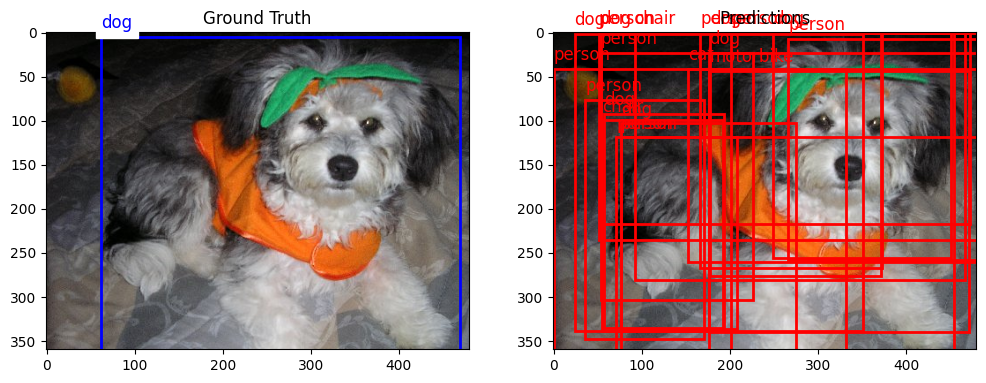

In [33]:
device = torch.device('cpu')
model.to(device)

model.eval()
with torch.no_grad():
    for images, targets in test_loader:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) if torch.is_tensor(v) else v for k, v in t.items()} for t in targets]

        # Make predictions
        predictions = model(images)

        # Visualize predictions for the first image in the batch
        visualize_predictions(images[0], targets[0], predictions[0])

        # Stop after a few examples
        break

## Training

In [34]:
# Move model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define training parameters
num_epochs = 10
learning_rate = 0.005
weight_decay = 0.0005

# Set up the optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=learning_rate, momentum=0.9, weight_decay=weight_decay)

# Set up the learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler

In [35]:
# Function to extract boxes and labels from target
def get_boxes_and_labels(target):
    boxes = []
    labels = []
    for obj in target['annotation']['object']:
        box = obj['bndbox']
        boxes.append([int(box['xmin']), int(box['ymin']), int(box['xmax']), int(box['ymax'])])
        labels.append(class_to_idx[obj['name']])
    return {
        "boxes": torch.as_tensor(boxes, dtype=torch.float32),
        "labels": torch.as_tensor(labels, dtype=torch.int64)
    }

In [36]:
# Training loop
loss_list = []
for epoch in range(num_epochs):
    model.train()
    i = 0
    epoch_loss = 0
    for images, targets in train_loader:
        # Move data to the appropriate device
        images = [image.to(device) for image in images]
        targets = [get_boxes_and_labels(t) for t in targets]
        targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(images, targets)

        # Compute losses
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        epoch_loss += losses.item()

        if i % 10 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{i + 10}/{len(train_loader)}], Loss: {losses.item():.4f}")
        i += 1

    loss_list.append(epoch_loss / len(train_loader))
    # Update the learning rate
    lr_scheduler.step()

print("Training complete.")


Epoch [1/10], Step [0/100], Loss: 0.6412
Epoch [1/10], Step [10/100], Loss: 0.8044
Epoch [1/10], Step [20/100], Loss: 0.5416
Epoch [1/10], Step [30/100], Loss: 0.6791
Epoch [1/10], Step [40/100], Loss: 0.4017
Epoch [1/10], Step [50/100], Loss: 0.4057
Epoch [1/10], Step [60/100], Loss: 0.5458
Epoch [1/10], Step [70/100], Loss: 0.4499
Epoch [1/10], Step [80/100], Loss: 0.3462
Epoch [1/10], Step [90/100], Loss: 0.3347
Epoch [2/10], Step [0/100], Loss: 0.3961
Epoch [2/10], Step [10/100], Loss: 0.4129
Epoch [2/10], Step [20/100], Loss: 0.3265
Epoch [2/10], Step [30/100], Loss: 0.5372
Epoch [2/10], Step [40/100], Loss: 0.3959
Epoch [2/10], Step [50/100], Loss: 0.2208
Epoch [2/10], Step [60/100], Loss: 0.3354
Epoch [2/10], Step [70/100], Loss: 0.4381
Epoch [2/10], Step [80/100], Loss: 0.2477
Epoch [2/10], Step [90/100], Loss: 0.2297
Epoch [3/10], Step [0/100], Loss: 0.3757
Epoch [3/10], Step [10/100], Loss: 0.2890
Epoch [3/10], Step [20/100], Loss: 0.1946
Epoch [3/10], Step [30/100], Loss: 0.

## Evaluation after training

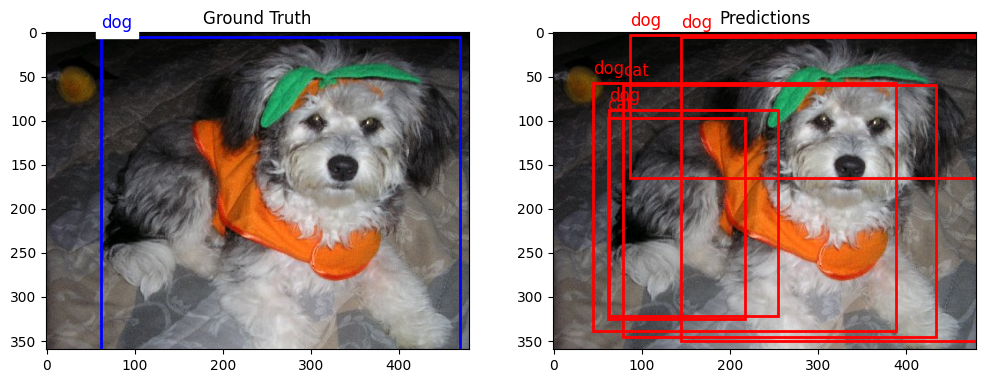

In [37]:
device = torch.device('cpu')
model.to(device)

model.eval()
with torch.no_grad():
    for images, targets in test_loader:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) if torch.is_tensor(v) else v for k, v in t.items()} for t in targets]

        # Make predictions
        predictions = model(images)

        # Visualize predictions for the first image in the batch
        visualize_predictions(images[0], targets[0], predictions[0])

        # Stop after a few examples
        break

In [38]:
# Function to apply NMS and filter predictions
def apply_nms(predictions, iou_threshold=0.5):
    # Perform Non-Maximum Suppression
    keep_indices = torchvision.ops.nms(predictions['boxes'], predictions['scores'], iou_threshold)
    predictions['boxes'] = predictions['boxes'][keep_indices]
    predictions['scores'] = predictions['scores'][keep_indices]
    predictions['labels'] = predictions['labels'][keep_indices]
    return predictions

({'annotation': {'filename': '2010_003007.jpg', 'folder': 'VOC2012', 'object': [{'name': 'dog', 'bndbox': {'xmax': '469', 'xmin': '62', 'ymax': '360', 'ymin': '5'}, 'difficult': '0', 'occluded': '0', 'pose': 'Unspecified', 'truncated': '0'}], 'segmented': '0', 'size': {'depth': '3', 'height': '360', 'width': '480'}, 'source': {'annotation': 'PASCAL VOC2010', 'database': 'The VOC2010 Database', 'image': 'flickr'}}}, {'annotation': {'folder': 'VOC2012', 'filename': '2008_005300.jpg', 'source': {'database': 'The VOC2008 Database', 'annotation': 'PASCAL VOC2008', 'image': 'flickr'}, 'size': {'width': '500', 'height': '379', 'depth': '3'}, 'segmented': '1', 'object': [{'name': 'cat', 'pose': 'Unspecified', 'truncated': '0', 'occluded': '0', 'bndbox': {'xmin': '26', 'ymin': '58', 'xmax': '467', 'ymax': '323'}, 'difficult': '0'}]}}, {'annotation': {'filename': '2010_004311.jpg', 'folder': 'VOC2012', 'object': [{'name': 'dog', 'bndbox': {'xmax': '414', 'xmin': '127', 'ymax': '371', 'ymin': '11

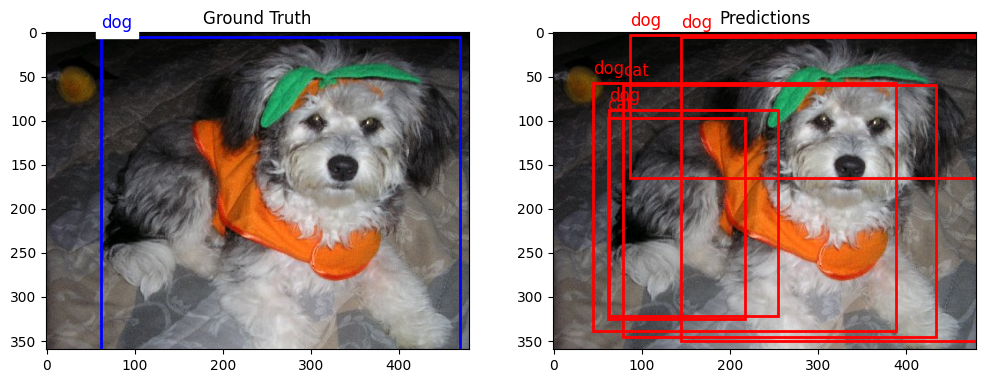

In [39]:
device = torch.device('cpu')
model.to(device)

model.eval()
with torch.no_grad():
    for images, targets in test_loader:
        print(targets)
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) if torch.is_tensor(v) else v for k, v in t.items()} for t in targets]

        # Make predictions
        predictions = model(images)

        # Visualize predictions for the first image in the batch
        visualize_predictions(images[0], targets[0], predictions[0])

        # Stop after a few examples
        break

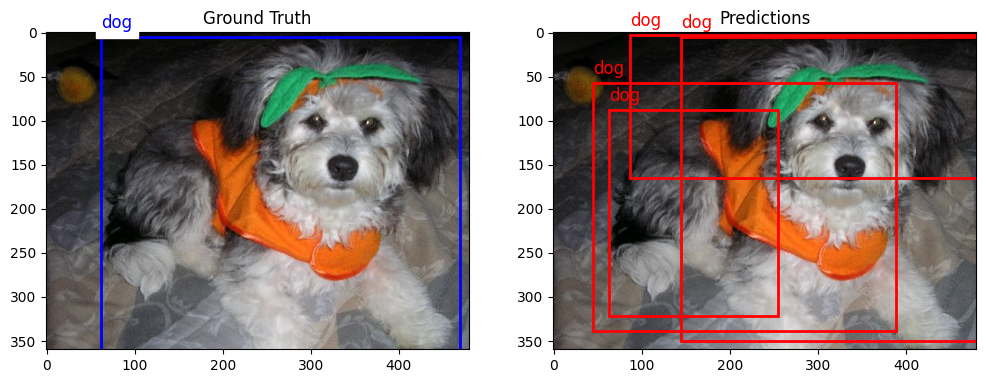

In [41]:
device = torch.device('cpu')
model.to(device)

model.eval()
with torch.no_grad():
    for images, targets in test_loader:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) if torch.is_tensor(v) else v for k, v in t.items()} for t in targets]

        # Make predictions
        predictions = model(images)

        # Apply NMS to the first image's predictions
        predictions[0] = apply_nms(predictions[0], iou_threshold=0.5)

        # Visualize predictions for the first image in the batch
        visualize_predictions(images[0], targets[0], predictions[0])

        # Stop after a few examples
        break